In [24]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt


import torch
#from torch import Tensor as tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

from scipy.integrate import odeint
from scipy.integrate import RK45

import torchdiffeq

from torch.autograd.functional import jacobian



use_cuda = torch.cuda.is_available() #also worsk for AMD-ROCm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


# Pendelum
$$\frac{d^2 \theta}{dt^2}  +  \lambda\frac{d\theta}{dt} +  \frac{g}{l}sin(\theta) $$

In [2]:
def pend(y,t,b,c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5

theta_0 = np.pi
omega_0 = 1
 
y0 = [theta_0 , omega_0]

t_final = 10

t = np.linspace(0,t_final,101)

sol = odeint(pend,y0, t, args=(b,c))


In [3]:
theta = sol[:, 0]
omega = sol[:, 1]

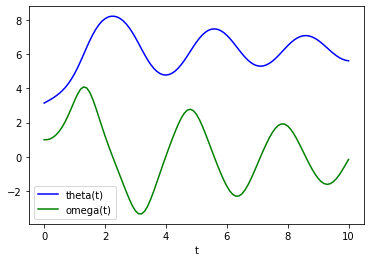

In [4]:
plt.plot(t, theta, 'b', label='theta(t)')
plt.plot(t, omega, 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 3, dtype=float),
            nn.ReLU(),
            nn.Linear(3, 3, dtype=float),
            nn.ReLU(),
            nn.Linear(3, 1, dtype=float)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

f = NeuralNetwork().to(device)

In [6]:
x_0 = torch.tensor([np.pi], dtype=float, requires_grad=True)
delta_t = 0.01

In [7]:
def euler_forward(func, x_0, t_0, t_1, delta_t, return_seq):
    time = torch.arange(start=t_0, end=t_1, step=delta_t, requires_grad=False)
    x = x_0.clone().detach() #makes copy of init-tensor and remvoes gradients
    if not return_seq:
        for t in time:
            x += delta_t*func(x)
        return x
    if return_seq:
        x_list = []
        for t in time:
            x += delta_t*func(x)
            x_list.append(x)
        return torch.tensor(x_list)


def one_euler_backward_step(func,x_1,delta_t):
    x = x_1.clone().detach()
    x -= delta_t * func(x)
    return x

def one_adjoint_backward_step(func, x_1, a_1, delta_t):

    a = a_1.clone().detach() 
    x = x_1.clone().detach()
    a -= delta_t * a * jacobian(func, x)

    return a



def get_gradient_with_respect_to_params(func, x):
    x = x.clone().detach()
    func(x).mean().backward()
    grads = []
    for param in func.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    f.zero_grad #<--- doesn't work
    return grads

def get_dL_dtheta(func, a_1, x_1, t_0, t_1, delta_t):
    time = torch.arange(start=t_0, end=t_1, step=delta_t, requires_grad=False)
    a = a_1.clone().detach() 
    x = x_1.clone().detach()
    result = torch.zeros( (a * get_gradient_with_respect_to_params(func, x)).shape)
    for t in time:
        result -= delta_t * a * get_gradient_with_respect_to_params(func, x)
        a = one_adjoint_backward_step(func, x, a, delta_t)
        x = one_euler_backward_step(func, x, delta_t)
    return result


def Loss_function(prediction):
    return (1/2  *  (theta[-1] - prediction)**2)
    

In [8]:
x_1 = euler_forward(f, x_0, 0, t_final,delta_t, False)
x_1

tensor([3.5308], dtype=torch.float64, grad_fn=<AddBackward0>)

In [10]:
loss = Loss_function(x_1)
loss

tensor([2.1752], dtype=torch.float64, grad_fn=<MulBackward0>)

In [11]:
a_1 = jacobian(Loss_function, x_1)
a_1

tensor([[-2.0857]], dtype=torch.float64)

In [23]:
get_dL_dtheta(f, a_1, x_1, 0, t_final, delta_t)

tensor([[  5182.3940,   2615.4062, -62377.1914,   3572.2505,   2093.1956,
          20063.4766,    464.5010,   1353.3417,   1707.2321,   1040.1328,
           3030.5242,   3822.8762,   1118.2527,   3258.1165,   4110.0825,
           8105.8228,  18150.9785,  19514.4199,  11215.4150,  15596.4209,
           8865.2666,  37163.9062]])

In [18]:
for param in f.parameters():
    param.data = nn.parameter.Parameter(torch.rand_like(param))

# Sanity check-


In [19]:
for param in f.parameters():
    print(param)

Parameter containing:
tensor([[0.2703],
        [0.6653],
        [0.0603]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.0263, 0.2417, 0.4640], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0.8103, 0.1916, 0.5303],
        [0.8317, 0.3430, 0.2151],
        [0.2263, 0.2908, 0.9295]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.3784, 0.6403, 0.1921], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0.4109, 0.9200, 0.9891]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.0126], dtype=torch.float64, requires_grad=True)


In [ ]:

optimizer = optim.RMSprop(f.parameters(), lr=1e-3)

for itr in range(1, args.niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % args.test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()